Shape = (10976, 803)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.3630456616886075
1  7.148988421301356
2  6.978267424267533
3  6.826357454051632
4  6.704887071142336
5  6.5828435964977645
6  6.493116154124492
7  6.411817871864744
8  6.346258890180259
9  6.293016469373482
10  6.246610363031027
11  6.1919067690588365
12  6.140011368305021
13  6.110238831964485
14  6.084608617303084
15  6.062997563495096
16  6.04464579172255
17  6.026963252994881
18  6.012232390244942
19  6.000026639372965
20  5.9795513264969395
21  5.965338105849863
22  5.954273627722914
23  5.943791293428638
24  5.923621004160904
25  5.918583876356445
26  5.91434551827621
27  5.909804185551389
28  5.907040226770113
29  5.902592834029362
30  5.8997178036117575
31  5.897522027690217
32  5.89547876248273
33  5.8924316303818145
34  5.890708140511691
35  5.889488801151628
36  5.886883846468237
37  5.885417235933989
38  5.884313696226665
39  5.878863558034402
40  5.876887443241236
41  5.875329178255314
42  5

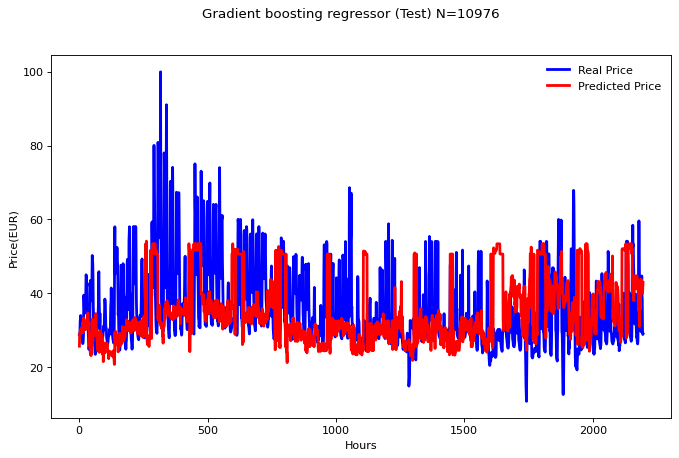

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/04_All_Feature.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

Y_temp = Y.copy()
Y_temp.index = Y_temp.index + DateOffset(hours=-hour_ahead)
Y_temp.rename('Y', inplace=True)
XY = X.copy()
XY = XY.join(Y_temp)
XYC = XY.corr()
YCorr = XYC.drop(First.columns.difference(['Y']), axis=1)
YCorr.sort_values(by=['Y'], inplace=True, ascending=False)



TopIndex = YCorr.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

Shape = (10976, 803)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.314764804861719
1  7.084116226772151
2  6.883332646096825
3  6.709191201890727
4  6.56189163243848
5  6.4308749103802425
6  6.32245562331813
7  6.226683477196313
8  6.14879135887178
9  6.076036456843647
10  6.023441804450187
11  5.9777235230862225
12  5.937583267671658
13  5.901261478714215
14  5.864923795158184
15  5.838735049235988
16  5.811981820636055
17  5.783631113017081
18  5.762407731424504
19  5.746163593539968
20  5.729466700576295
21  5.715385907199389
22  5.706949916469511
23  5.697167443397798
24  5.689769197726062
25  5.677444818432597
26  5.668539382041131
27  5.6620176322897935
28  5.6588248524855
29  5.655135774382772
30  5.649370109819422
31  5.642382885213051
32  5.640245108594968
33  5.636012270745609
34  5.633185972888641
35  5.631890814539912
36  5.629714322284702
37  5.626212538102824
38  5.626366744131033
39  5.624812688928698
40  5.6246407810488535
41  5.6242525643535
42  5.62222

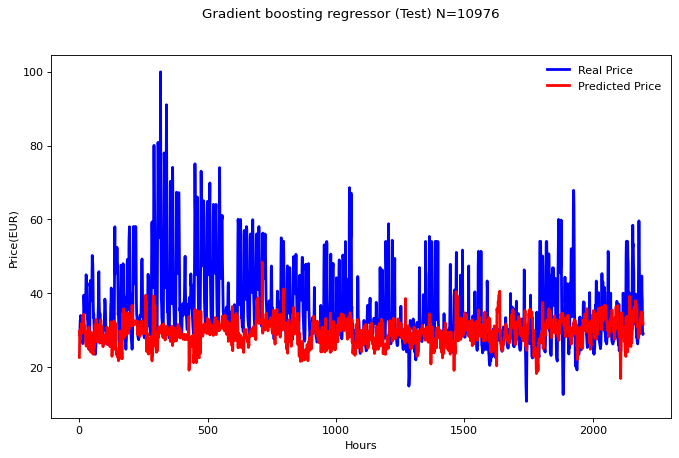

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/04_All_Feature.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

Y_temp = Y.copy()
Y_temp.index = Y_temp.index + DateOffset(hours=-hour_ahead)
Y_temp.rename('Y', inplace=True)
XY = X.copy()
XY = XY.join(Y_temp)
XYC2 = XY.corr(method='spearman')
YCorr2 = XYC2.drop(First.columns.difference(['Y']), axis=1)
YCorr2.sort_values(by=['Y'], inplace=True, ascending=False)




TopIndex = YCorr2.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

Shape = (10976, 803)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.147266511787825
1  6.782720108364108
2  6.460751510310386
3  6.206176799944977
4  5.996148845462129
5  5.8308299313296175
6  5.718401552352781
7  5.600643312179287
8  5.529715697249989
9  5.451490719096334
10  5.397719891803326
11  5.275149815596305
12  5.227818482505172
13  5.19572558371068
14  5.119066473730842
15  5.089779905538888
16  5.049895395386172
17  5.01536738209716
18  4.996085933313764
19  4.952710269748119
20  4.924921544048395
21  4.900083704697938
22  4.880124922143845
23  4.863880393260886
24  4.853736121583383
25  4.842085527500117
26  4.8325332568671024
27  4.825922829642249
28  4.810628703511609
29  4.804862191425168
30  4.8002766072591205
31  4.7922729544585865
32  4.788662026782422
33  4.785651843617632
34  4.780610186865589
35  4.777184230908316
36  4.773911100077823
37  4.770906495428508
38  4.768606472294734
39  4.764764735187679
40  4.762331612170412
41  4.760245794308099
42  4.

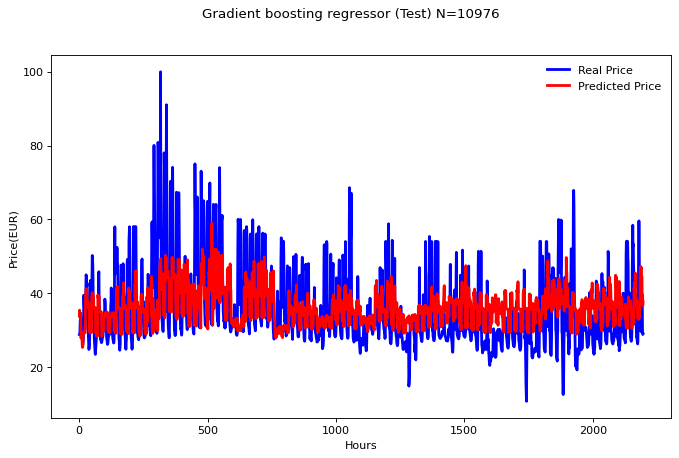

In [4]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/04_All_Feature.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(X, Y)
importance2 = model2.coef_
FeatureR = []
FeatureR_index = X.columns
for i,v in enumerate(importance2):
    FeatureR.append(v)

Yfri = pd.DataFrame({'Index':FeatureR_index})
Yfr = pd.DataFrame({'Y':FeatureR})
Yfr.index = Yfri['Index']
Yfr.sort_values(by=['Y'], inplace=True, ascending=False)




TopIndex = Yfr.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()